## Azure Document Intelligence

In [5]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader
from IPython.display import Markdown

load_dotenv()

doc_intelligence_endpoint = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT")
doc_intelligence_key = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY")
loader = AzureAIDocumentIntelligenceLoader(file_path="../data/Wine-PO.pdf", api_key = doc_intelligence_key, api_endpoint = doc_intelligence_endpoint, api_model="prebuilt-layout")
docs = loader.load()
Markdown(docs[0].page_content)

## Azure OpenAI Vision

In [1]:
from langchain_openai import AzureChatOpenAI
import os
from dotenv import load_dotenv
load_dotenv() 

llm = AzureChatOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    openai_api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    openai_api_version=os.getenv("OPENAI_API_VERSION"),
    azure_deployment="gpt-4o",
    temperature=0,
)

In [3]:
from pdf2image import convert_from_path

def pdf_to_images(pdf_path, output_folder):
    """
    Convert a PDF file into images, one image per page.
    """
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert PDF to a list of PIL Image objects
    images = convert_from_path(pdf_path)
    
    # Save each image to the output folder
    for i, image in enumerate(images):
        image_path = f"{output_folder}/page_{i + 1}.png"
        image.save(image_path, 'PNG')
        print(f"Saved {image_path}")

# Example usage
pdf_path = '../data/Wine-PO.pdf'
output_folder = 'output'
pdf_to_images(pdf_path, output_folder)

Saved output/page_1.png


In [7]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List

class Item(BaseModel):
    item_name: str = Field(description="Item Name")
    quantity: int = Field(description="Quantity")
    item_price: float = Field(description="Item Price")
    item_discount: float = Field(description="Item Discount")
    total: float = Field(description="Total Price")

class Order(BaseModel):
    po_number: str = Field(description="PO Number")
    order_status: str = Field(description="Order Status")
    client_id: str = Field(description="Client ID")
    customer_contact_name: str = Field(description="Customer Contact Name")
    customer_company_name: str = Field(description="Customer Company Name")
    customer_address: str = Field(description="Customer Address")
    supplier_contact_name: str = Field(description="Supplier Contact Name")
    supplier_company_name: str = Field(description="Supplier Company Name")
    supplier_address: str = Field(description="Supplier Address")
    delivery_date: str = Field(description="Delivery Date")
    order_total: float = Field(description="Order Total")
    subtotal: float = Field(description="Subtotal")
    sales_tax: float = Field(description="Sales Tax")
    shipping_cost: float = Field(description="Shipping Cost")
    other_costs: float = Field(description="Other Costs")
    items: List[Item] = Field(description="Items")

System: You are an expert financial analyst. Use you knowledge base to answer questions about audited financial statements.
Human: [{'type': 'text', 'text': 'Extract the information as specified.\nThe output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"po_number": {"title": "Po Number", "description": "PO Number", "type": "string"}, "order_status": {"title": "Order Status", "description": "Order Status", "type": "string"}, "client_id": {"title": "Client Id", "description": "Client ID", "type": "string"}, "customer_contact_name": {"title": "Customer Contact Name", "descriptio
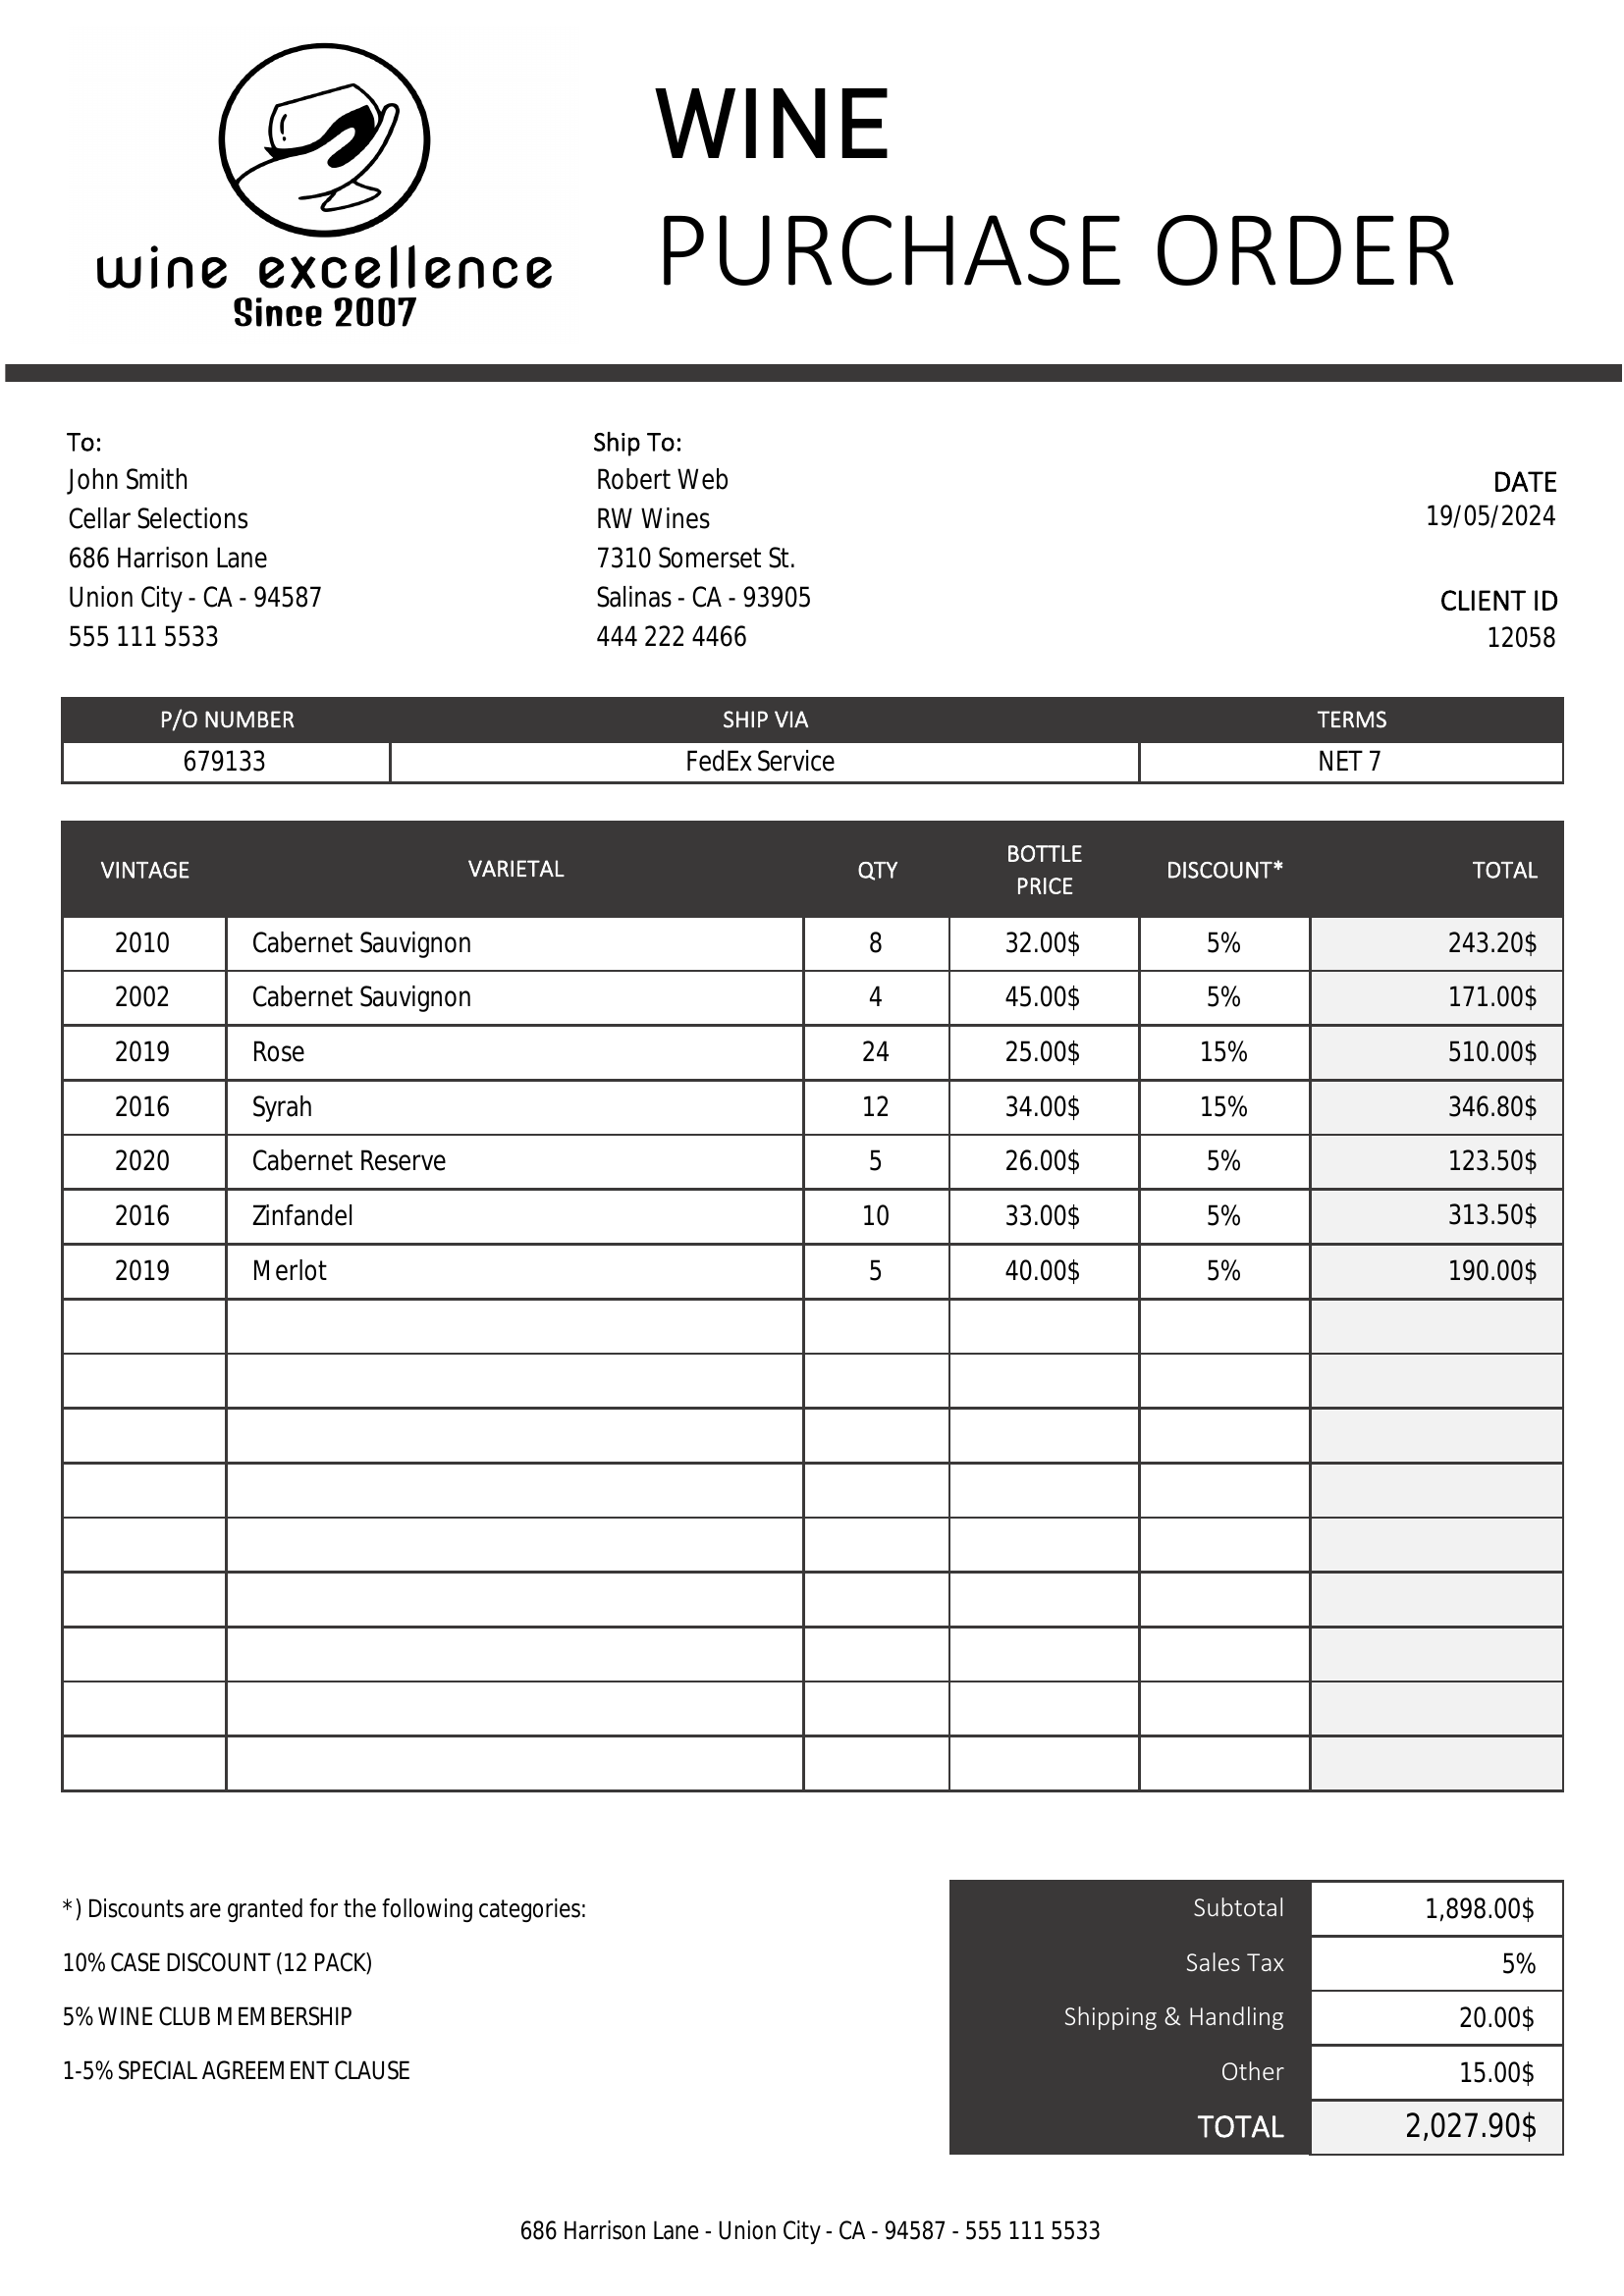

In [17]:
from langchain_core.prompts import HumanMessagePromptTemplate, ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

parser = JsonOutputParser(pydantic_object=Order)

image_path = 'output/page_1.png'
detail_parameter = 'high'

chat_prompt_template = ChatPromptTemplate(
    messages=[
        SystemMessage(content="You are an expert financial analyst. Use you knowledge base to answer questions about audited financial statements."),        
        HumanMessagePromptTemplate.from_template(
            [{"text": "Extract the information as specified.\n{format_instructions}"},
            {'image_url': {'path': '{image_path}', 'detail': '{detail_parameter}'}}]
        )
    ],
    partial_variables={"format_instructions": parser.get_format_instructions()},

)
prompt = chat_prompt_template.format(
    image_path=image_path, 
    detail_parameter=detail_parameter,
    format_instructions=parser.get_format_instructions())

chain = chat_prompt_template | llm | parser

chain.get_prompts()

response = chain.invoke({
    "image_path": image_path,
    "detail_parameter": detail_parameter
})

In [19]:
print(response)

{'po_number': '679133', 'order_status': 'NET 7', 'client_id': '12058', 'customer_contact_name': 'John Smith', 'customer_company_name': 'Cellar Selections', 'customer_address': '686 Harrison Lane, Union City, CA - 94587', 'supplier_contact_name': 'Robert Web', 'supplier_company_name': 'RW Wines', 'supplier_address': '7310 Somerset St., Salinas, CA - 93905', 'delivery_date': '19/05/2024', 'order_total': 2027.9, 'subtotal': 1898.0, 'sales_tax': 94.9, 'shipping_cost': 20.0, 'other_costs': 15.0, 'items': [{'item_name': 'Cabernet Sauvignon (2010)', 'quantity': 8, 'item_price': 32.0, 'item_discount': 5, 'total': 243.2}, {'item_name': 'Cabernet Sauvignon (2002)', 'quantity': 4, 'item_price': 45.0, 'item_discount': 5, 'total': 171.0}, {'item_name': 'Rose (2019)', 'quantity': 24, 'item_price': 25.0, 'item_discount': 15, 'total': 510.0}, {'item_name': 'Syrah (2016)', 'quantity': 12, 'item_price': 34.0, 'item_discount': 15, 'total': 346.8}, {'item_name': 'Cabernet Reserve (2020)', 'quantity': 5, '